# Antibiotic Exposure and Risk of Antimicrobial Resistance in Hospitalized Patients

**Author:** Uzoma Uzoma, *MD*  
**Date:** 14 January 2026 

---

## Background
Antibiotic resistance is a growing challenge in hospital settings, where antimicrobial use is frequent and often prolonged. While the association between antibiotic exposure and resistance is well established, understanding how resistance emerges over time in relation to antibiotic exposure during hospitalization is critical for effective antimicrobial stewardship.

Hospitalized patients represent a unique population because antibiotic therapy is closely tied to discrete admission episodes, with clearly defined start and stop times. This allows antibiotic exposure to be studied as a time-dependent process, rather than as a simple binary variable. Analyses that ignore timing risk misclassifying exposure and may produce biased estimates of risk.

---

## Aim
The aim of this project is to examine the temporal relationship between antibiotic exposure and the emergence of resistance during hospitalization, using synthetic electronic health record data. Antibiotic exposure was quantified at the admission level to preserve timing information, while cumulative exposure across admissions was summarized at the patient level to characterize overall antibiotic burden. Resistance emergence was modeled as a time-to-event outcome, enabling survival analysis methods to assess how increasing antibiotic exposure relates to earlier resistance.

---

## Strength and Limitation
Although the data are synthetic, the analytical pipeline mirrors real-world clinical data workflows and is designed to be transferable to hospital datasets containing medication administration records and microbiology outcomes.

## Table of Contents

1. [Background](#background)
2. [Load Data](#load-data)
3. [Temporal Analysis](#temporal-analysis)
4. [Cumulative Analysis](#cumulative-analysis)
5. [Conclusion](#conclusion)

## Load Data

In [2]:
# Import required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import statsmodels.api as sm

In [3]:
# Global Variables
exposure_categories=['Short (1-5)', 'Medium (6-14)', 'High (15-30)', 'Very High (>30)']

In [ ]:
# Get prepared csv files
admission_resistance = pd.read_csv('../data/admission_level_with_resistance.csv')
patient_exposure = pd.read_csv('../data/patient_level_cumulative_exposure.csv')

<a id='temporal-analysis'></a>
## Temporal (Admission-Level) Analysis

### Aim
- To evaluate the time from hospital admission to the emergence of antibiotic resistance among hospitalized patients  
- To assess how the duration of inpatient antibiotic exposure influences the timing of resistance development  

### Methods
- Time-to-event and event indicator variables were constructed for each hospital admission  
- Kaplan–Meier survival curves were used to visualize time to resistance across antibiotic exposure levels  
- Differences between survival curves were assessed using log-rank testing  
- A Cox proportional hazards model was fitted to estimate the association between antibiotic exposure duration and the hazard of resistance  

### Visualizations
- Kaplan–Meier survival curves illustrating time to resistance by antibiotic exposure category  
- Forest-style error bar plot displaying hazard ratios with 95% confidence intervals from the Cox model  


In [5]:
# Create time and event columns for analysis

# Time
admission_resistance['time'] = admission_resistance['resistance_day']
# If no resistance, time should be at end of antibiotics
admission_resistance.loc[admission_resistance['resistance_event']==0, 'time'] = admission_resistance['total_abx_days']

# Event 
admission_resistance['event'] = admission_resistance['resistance_event']

C:\Users\UZOMA\AppData\Local\Temp\ipykernel_7888\4154351259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for label, group in admission_resistance.groupby('exposure_category'):


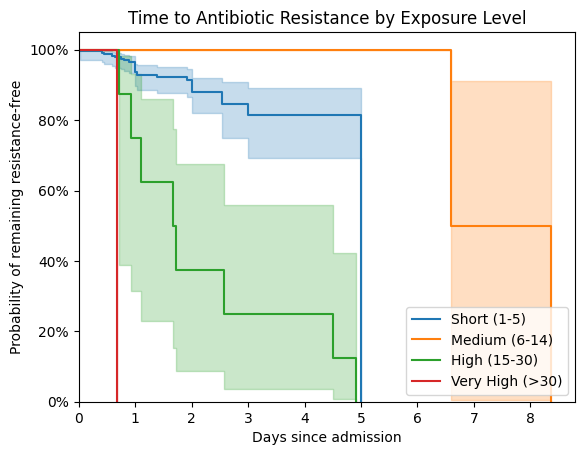

In [7]:
# Plot time to event curve

kmf = KaplanMeierFitter()

# Convert exposure category to ordered categorical variable
admission_resistance['exposure_category'] = pd.Categorical(
    admission_resistance['exposure_category'],
    categories=exposure_categories,
    ordered=True
)

# Plot curves
for label, group in admission_resistance.groupby('exposure_category'):
    kmf.fit(
        durations=group['time'],
        event_observed=group['event'],
        label=label
    )
    kmf.plot_survival_function()

# Label chart
plt.title('Time to Antibiotic Resistance by Exposure Level')
plt.xlabel('Days since admission')
plt.ylabel('Probability of remaining resistance-free')
plt.xlim(0,)
plt.ylim(0,)

# Convert y-axis values to % 
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.show()

In [ ]:
# Statistical significance

low = admission_resistance[admission_resistance['exposure_category'] == 'Short (1-5)']
high = admission_resistance[admission_resistance['exposure_category'] == 'High (15-30)']

result = logrank_test(
    durations_A=low['time'],
    durations_B=high['time'],
    event_observed_A=low['event'],
    event_observed_B=high['event']
)

print(f"Test statistic: {result.test_statistic:.2f}\np-value: {result.p_value:.3f}")
# Test statistic: 21.66
# p-value: <.001
# Thus, timing of resistance differs significantly by exposure

Test statistic: 21.66
p-value: 0.000


In [ ]:
# Cox Proportional Hazards

cox_df = admission_resistance[['time', 'event', 'total_abx_days']].dropna()

cph = CoxPHFitter()

cph.fit(cox_df, duration_col='time', event_col='event')

summary = cph.summary.reset_index()
# Every extra day on antibiotic increased probabiliy of developing resistance by 4%

summary

,covariate,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
0,total_abx_days,0.035736,1.036382,0.00735,0.02133,0.050142,1.021559,1.051421,0.0,4.861884,0.000001,19.714041


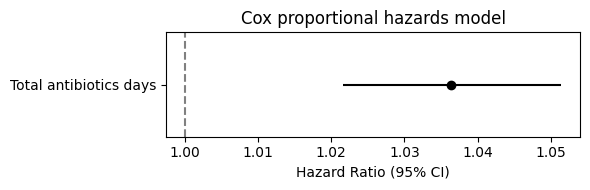

In [ ]:
# Visualise Cox proportional hazard model

hr = summary['exp(coef)']
lower = summary['exp(coef) lower 95%']
upper = summary['exp(coef) upper 95%']

plt.figure(figsize=(6, 2))

plt.errorbar(
    hr,
    'Total antibiotics days',
    xerr=[hr - lower, upper - hr],
    fmt='o',
    color='black'
)

plt.axvline(x=1, linestyle='--', color='grey')  # HR = 1 line
plt.xlabel("Hazard Ratio (95% CI)")
plt.title("Cox proportional hazards model")

plt.tight_layout()
plt.show()

<a id='cumulative-analysis'></a>
## Cumulative (Patient-Level) Analysis

### Aim
- To quantify cumulative inpatient antibiotic exposure at the patient level  
- To describe the distribution of cumulative antibiotic exposure across patients  
- To examine the association between cumulative antibiotic exposure and the occurrence of resistance  
- To complement admission-level temporal analyses with a population-level risk perspective  

### Methods and Visualizations
- A histogram was used to visualize the distribution of cumulative antibiotic exposure (in days) per patient  
- Patients were stratified into cumulative exposure categories to summarize overall antibiotic burden  
- A patient-level resistance indicator (ever vs never resistant) was derived and visualized across exposure categories using a point plot  
- A simple logistic regression model was applied to assess the relationship between cumulative antibiotic exposure and the probability of resistance  


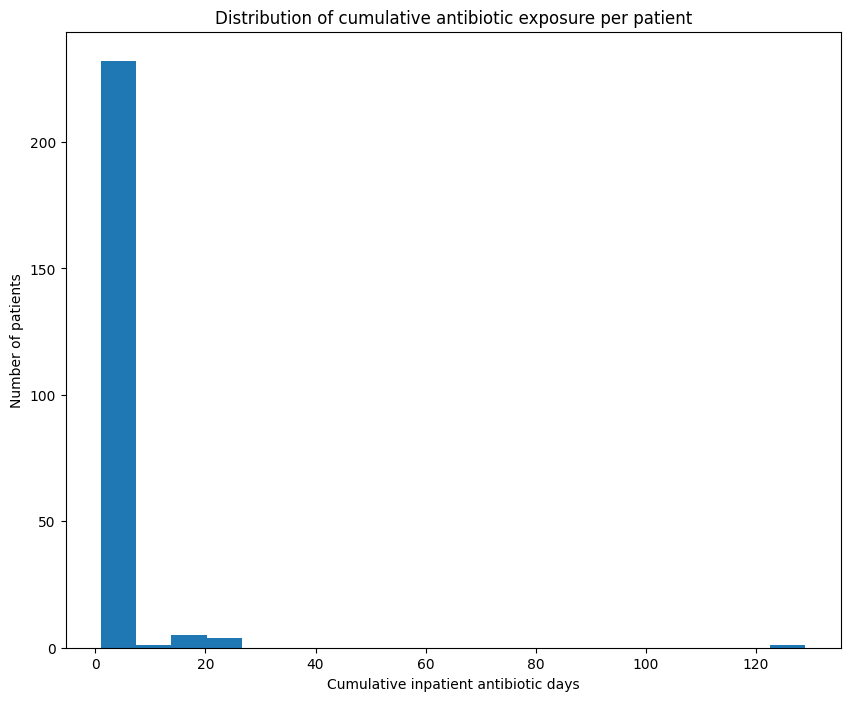

In [ ]:
# Exposure burden distribution

plt.figure(figsize=(10,8))

plt.hist(patient_exposure['cumulative_abx_days'], bins=20)

plt.xlabel('Cumulative inpatient antibiotic days')
plt.ylabel('Number of patients')
plt.title('Distribution of cumulative antibiotic exposure per patient')
plt.show()

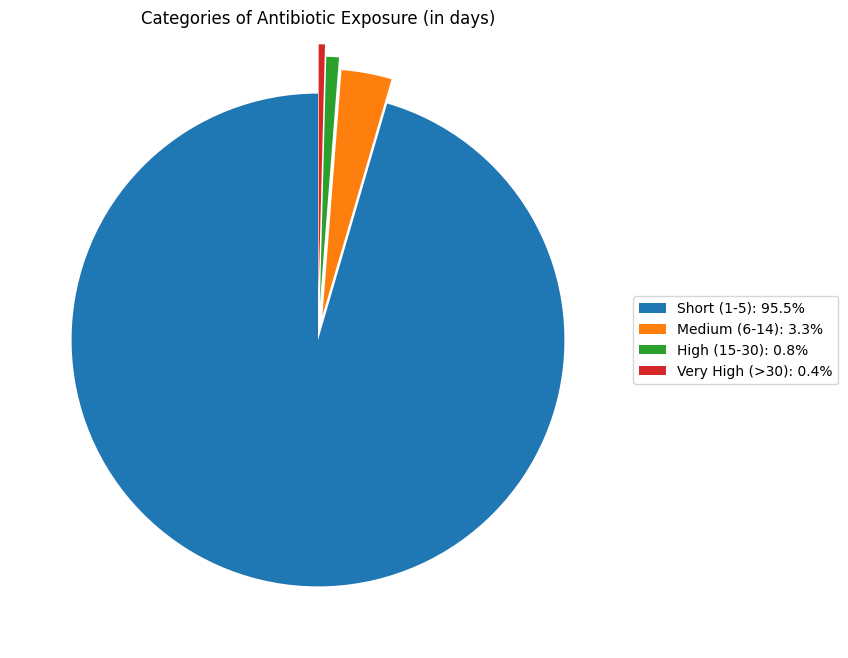

In [ ]:
# Visualise exposure category distribution

patient_exposure['exposure_category'] = pd.Categorical(
    patient_exposure['exposure_category'],
    categories=exposure_categories,
    ordered=True
)

values = patient_exposure['exposure_category'].value_counts()
percentages = values/values.sum() * 100

plt.figure(figsize=(10,8))

plt.pie(
    values, 
    startangle=90,
    explode=[0, .1, .15, .2],
    )
plt.legend(
    labels=[f"{l}: {p:.1f}%" for l, p in zip(exposure_categories, percentages)],
    loc='center left',
    bbox_to_anchor=(1, 0.5)
)
plt.title('Categories of Antibiotic Exposure (in days)')
plt.show()


In [ ]:
# Link patient exposure to resistance

patient_resistance = (
    admission_resistance
    .groupby('PATIENT')['resistance_event']
    .max()
    .reset_index(name='ever_resistant')
)

patient_exposure = patient_exposure.merge(
    patient_resistance,
    on='PATIENT',
    how='left'
)

Text(0.5, 1.0, 'Patient-level risk of resistance by cumulative antibiotic exposure')

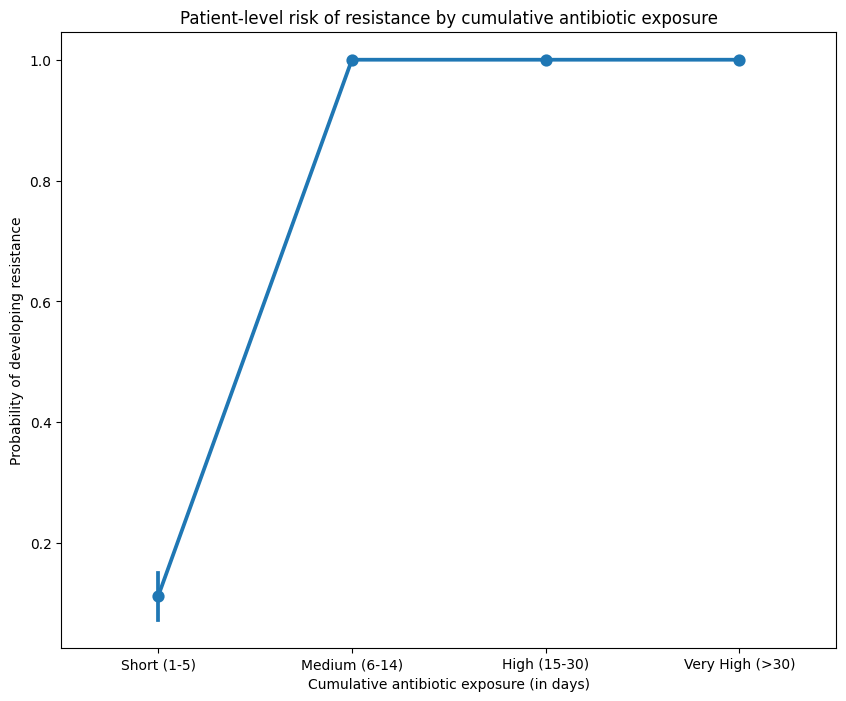

In [ ]:
# Visualise with box plot
plt.figure(figsize=(10,8))

sns.pointplot(data=patient_exposure, x='exposure_category', y='ever_resistant', order=exposure_categories)

plt.xlabel('Cumulative antibiotic exposure (in days)')
plt.ylabel('Probability of developing resistance')
plt.title('Patient-level risk of resistance by cumulative antibiotic exposure')

In [ ]:
# Logistic regression

x = patient_exposure[['cumulative_abx_days']]
x = sm.add_constant(x)
y = patient_exposure['ever_resistant']

model = sm.Logit(y, x).fit()

model.summary()

Optimization terminated successfully.
         Current function value: 0.322798
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         ever_resistant   No. Observations:                  243
Model:                          Logit   Df Residuals:                      241
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                  0.2434
Time:                        22:55:09   Log-Likelihood:                -78.440
converged:                       True   LL-Null:                       -103.67
Covariance Type:            nonrobust   LLR p-value:                 1.219e-12
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.3397      0.566     -5.898      0.000      -4.449      -2.230
cumulative_abx_days     0.6758      0.260      2.598      0.009       0.166       1.186
=======================================================================================
"""

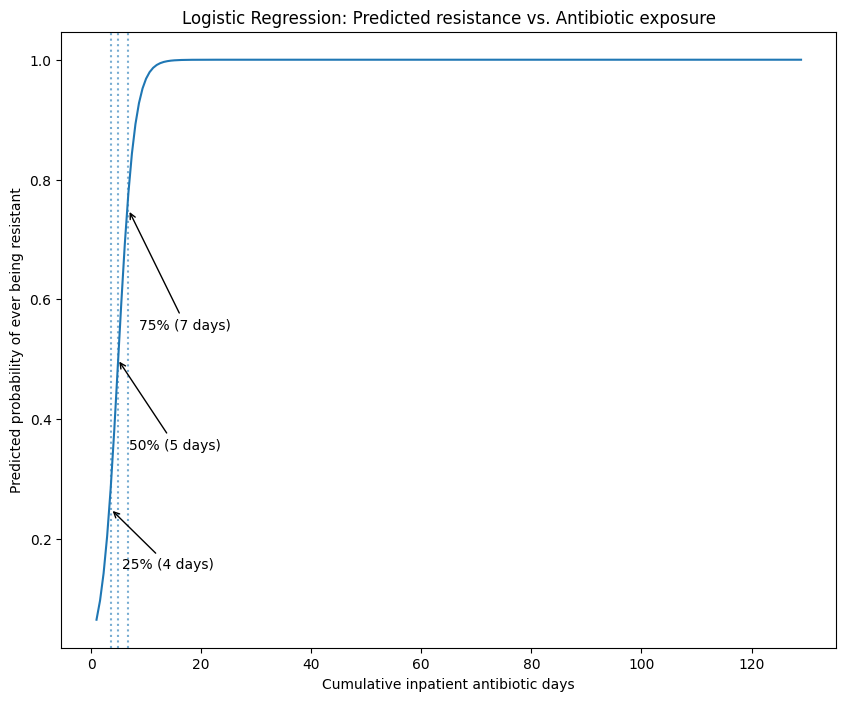

In [ ]:
# Visualise the regression plot

# Create grid and prediction for plot
x_grid = np.linspace(
    patient_exposure['cumulative_abx_days'].min(), 
    patient_exposure['cumulative_abx_days'].max(), 
    200
    )
x_pred = pd.DataFrame({'cumulative_abx_days': x_grid})
x_pred = sm.add_constant(x_pred)

x_pred = model.predict(x_pred)

# Plot chart
plt.figure(figsize=(10,8))
plt.plot(x_grid, x_pred)

# Display probability thresholds on chart
for threshold, y_text in zip([0.25, 0.5, 0.75], [0.15, 0.35, 0.55]):
    idx = np.argmin(np.abs(x_pred - threshold))
    x_thr = x_grid[idx]

    plt.axvline(x=x_thr, linestyle=':', alpha=0.6)

    plt.annotate(
        f'{int(threshold*100)}% ({round(x_thr)} days)',
        xy=(x_thr, threshold),
        xytext=(x_thr + 2, y_text),
        arrowprops=dict(arrowstyle='->', lw=1),
        rotation=0
    )

# Label chart
plt.xlabel('Cumulative inpatient antibiotic days')
plt.ylabel('Predicted probability of ever being resistant')
plt.title('Logistic Regression: Predicted resistance vs. Antibiotic exposure')
plt.show()

## Conclusion

This project demonstrates a complete, end-to-end health data analytics workflow for studying antibiotic resistance in hospitalized patients. Using synthetic electronic health record data, antibiotic exposure was engineered at both the admission and patient levels, with careful attention to timing, cumulative burden, and bias-aware modeling. 

Temporal analyses showed that longer inpatient antibiotic exposure was associated with earlier resistance events, while patient-level summaries highlighted how cumulative exposure can be used to identify higher-risk patients. 

Although resistance outcomes were simulated, the data processing and analytical approach closely reflect real-world hospital data pipelines and can be directly applied to clinical datasets. Overall, this work highlights practical skills in longitudinal data engineering, survival analysis, and clear communication of clinically relevant insights.
